# The COMPAS Project: A Computational Database of Polycyclic Aromatic Systems. Phase 2: _cata_-condensed Hetero-Polycyclic Aromatic Systems

## The Effect of Sulfur on E_tot

# Summary
This Jupyter Notebook provides the calculations and analysis for section S5 of the supporting information. 

In [3]:
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem

from pathlib import Path
import json
import re

import numpy as np
import pandas as pd

from datetime import datetime
from tqdm import tqdm

TIMESPAM = datetime.now().strftime("%y%m%d_%H%M%S")

import mols2grid

import matplotlib.pyplot as plt
import seaborn as sns
from utils.func import calc_gap, calc_aea_aip
from utils.regression import prepare_model


# training different models and comparing them
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, ARDRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
# import standar scaler
from sklearn.preprocessing import StandardScaler
# import deepcopy
from copy import deepcopy

from utils import plotting

from utils.regression import Regressor, random_split, sabya_split
# show all pandas columns in vscode
pd.set_option('display.max_columns', None)

# set autoreload
%load_ext autoreload
%autoreload 2


DATA_FOLDER = Path('data')
FIGURE_FOLDER = Path('figures')
FIGURE_S3 = FIGURE_FOLDER / 'figure_s3'
BENCHMARK_FOLDER = DATA_FOLDER / 'benchmark'

FIGURE_S3.mkdir(exist_ok=True,parents=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# read the compas-2x and compas-2D datasets
df_xtb = pd.read_csv('../compas-2x.csv', index_col=0)
df_dft = pd.read_csv('../compas-2D.csv', index_col=0)


# merge the datasets
data = pd.merge(df_xtb.drop(columns=['formula', 'inchi', 'smiles', 
                                     'h', 'c', 'b', 's', 'o', 'n',
                                     'cyclobutadiene',
       'pyrrole', 'borole', 'furan', 'thiophene', 'dhdiborine', '14diborine',
       'pyrazine', 'pyridine', 'borinine', 'benzene'
                                     ]),
                df_dft, on=['name', 'charge'], suffixes=('_xtb', '_dft'))

# make columns names shorter
mapper = {'electron_affinity_xtb': 'aea_xtb',
            'electron_affinity_dft': 'aea_dft',
            'ionization_potential_xtb': 'aip_xtb',
            'ionization_potential_dft': 'aip_dft',
}
data = data.rename(columns=mapper)

In [5]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

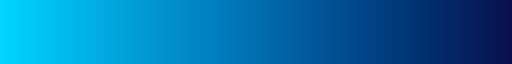

In [6]:
# make a cmap
import matplotlib.colors
norm = matplotlib.colors.Normalize(0,1)
colors = [
        [0, "#01d5ff"], #  
        [0.2, "#00abe2"], # 
        [0.4, "#0082c1"], # 
        [0.6, "#005a9d"], # 
        [0.8, "#003576"], # 
        [1, "#09114d"], #       

        ]

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
cmap

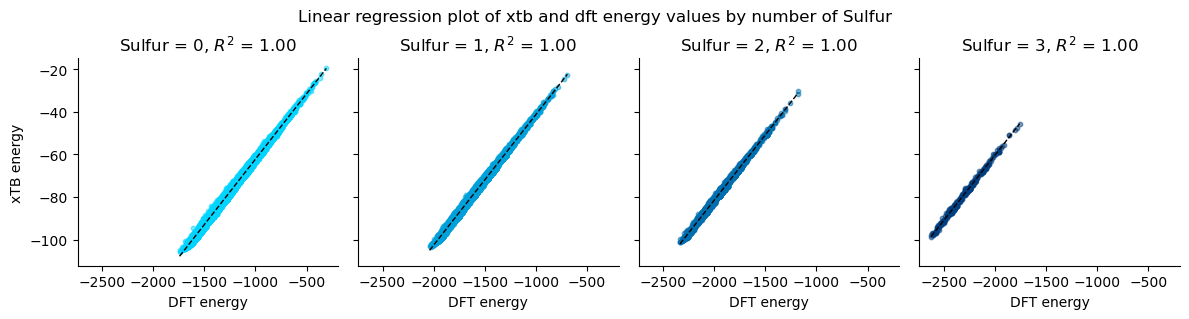

In [7]:
# calculate the r2 value for the xtb and dft energy values for each different thiophene value
r2_scores = data.groupby("s").apply(lambda x: r2(x["energy_xtb"], x["energy_dft"]))

axs = sns.lmplot(data=data[data["s"] != 4],x="energy_dft", y="energy_xtb",
  hue="s", col="s", col_wrap=4, height=3, palette=cmap(r2_scores.index/4),
  scatter_kws={"s": 10, "alpha": 0.5},
  line_kws={"color":"black", "lw":1, "ls":'--'})
axs.set_axis_labels("DFT energy", "xTB energy")
axs.fig.suptitle("Linear regression plot of xtb and dft energy values by number of Sulfur", y=1.05)
# add r2 score to the title of the plot
titles = [f"Sulfur = {s}, $R^2$ = {r2_score:.2f}" for s, r2_score in zip(r2_scores.index, r2_scores)]
for ax, title in zip(axs.axes.flat, titles):
    ax.set_title(title)

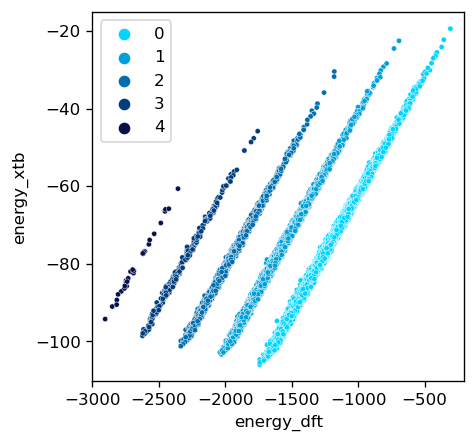

In [8]:
plt.figure(figsize=(4,4),dpi=120)
ax = sns.scatterplot(data=data, x="energy_dft", y="energy_xtb", hue="s", s=10,
palette = cmap)
# change the legend title
plt.legend(title="Sulfur atoms")
# ax x lim -3000 a 400/
ax.set_xlim(-3000, -200)
plt.legend()
plt.savefig(FIGURE_S3 / "energy_dft_vs_xtb_sulfur_color.png", dpi=300, transparent=True, bbox_inches="tight")
# svg
plt.savefig(FIGURE_S3 / "energy_dft_vs_xtb_sulfur_color.svg", dpi=300, transparent=True, bbox_inches="tight")

r2: 0.9979956852525519, rmse: 13.38177579484276, mae: 10.656502031901187, pearson: 0.9989973511491501
equation features = ['s']: 
y = 16.213197*energy_xtb + -343.475491*s +  8.715048


r2: 0.9999999940088862, rmse: 0.023135802857333222, mae: 0.01825958051493965, pearson: 0.9999999970044476
equation features = ['h', 'c', 'b', 's', 'o', 'n']: 
y = 0.788027*energy_xtb + -0.210198*h + -36.379306*c + -23.693237*b + -395.194704*s + -71.459700*o + -52.192276*n +  0.128544


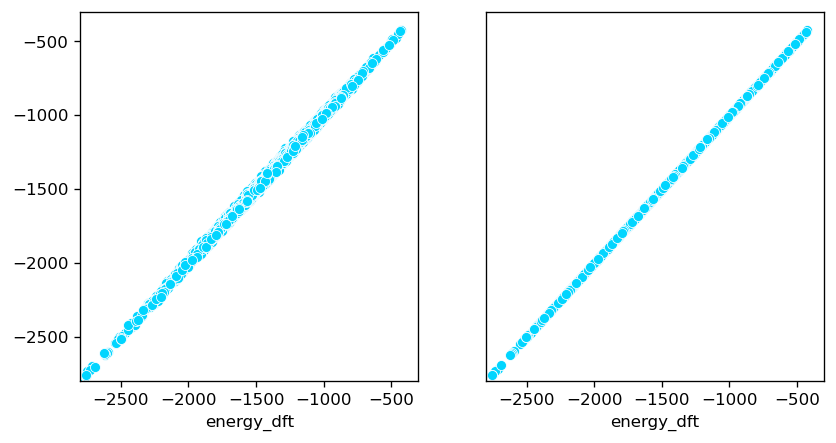

In [9]:
# target and features
target = 'energy_dft'
features = ['energy_xtb']
# atoms
atoms = ['h', 'c', 'b', 's', 'o', 'n']
# structure features
descriptors = ['nrings','nbranch']
features += 's' #+ bblocks + descriptors

model_energy_s = Regressor(LinearRegression(), data, target, features)
model_energy_s.train_test_split(splitter=random_split,test_size=0.2)
model_energy_s.make_pipeline()

r2, rmse, mae, p = model_energy_s.fit_predict_evaluate()
print(f'r2: {r2}, rmse: {rmse}, mae: {mae}, pearson: {p}')
# print the equation
print("equation features = ['s']: ")
model_energy_s.print_equation()
print("\n")

# target and features
target = 'energy_dft'
features = ['energy_xtb']
# atoms
atoms = ['h', 'c', 'b', 's', 'o', 'n']
# structure features
descriptors = ['nrings','nbranch']
features += atoms #+ bblocks + descriptors

model_energy_all = Regressor(LinearRegression(), data, target, features)
model_energy_all.train_test_split(splitter=random_split,test_size=0.2)
model_energy_all.make_pipeline()

r2, rmse, mae, p = model_energy_all.fit_predict_evaluate()
print(f'r2: {r2}, rmse: {rmse}, mae: {mae}, pearson: {p}')
# print the equation
print("equation features = ['h', 'c', 'b', 's', 'o', 'n']: ")
model_energy_all.print_equation()
# make a scatter plot of the predicted vs the real values
fig, axs = plt.subplots(1, 2, figsize=(8,4), dpi=120)


# make a scatter plot of the predicted vs the real values
ax = sns.scatterplot(x=model_energy_s.y_test, y=model_energy_s.y_pred, c="#01D5FF", ax=axs[0])
ax.set_xlim(-2800, -300)
ax.set_ylim(-2800, -300)

ax = sns.scatterplot(x=model_energy_all.y_test, y=model_energy_all.y_pred, c="#01D5FF", ax=axs[1])
ax.set_xlim(-2800, -300)
ax.set_ylim(-2800, -300)
#hide y axis
ax.axes.get_yaxis().set_visible(False)
# save the figure as svg and png
plt.savefig(FIGURE_S3 / "energy_dft_vs_xtb_sulfur_atoms.png", dpi=300, bbox_inches="tight", transparent=True)
# svg
plt.savefig(FIGURE_S3 / "energy_dft_vs_xtb_sulfur_atoms.svg", dpi=300, bbox_inches="tight", transparent=True)